In [1]:
# import relevant depedencies
using LinearAlgebra
using TensorKit
using MPSKit
using Plots
using LaTeXStrings
using Statistics
using Colors
using ProgressMeter
using Plots.PlotMeasures
using Printf
using CurveFit
using Polynomials
include("julia_functions.jl")



Trivertex_classical_ising_partition_function (generic function with 2 methods)

For the compression of matrix product states, the dependency of the computational cost on certain variables should be well understood

First of all measure the influence L on the computation time to optimize the MPS using:\
\
R^10 => R^5    \
sigma = R^2 \
DMRG1


┌ Warning: dmrg failed to converge 0.008792998372469269>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 0.008792998372469269>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 0.005427894455997435>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
Progress:   2%|▉                                        |  ETA: 0:27:11┌ Warning: dmrg failed to converge 0.00396744354278681>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 0.015320779316358158>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 0.010486688890680208>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


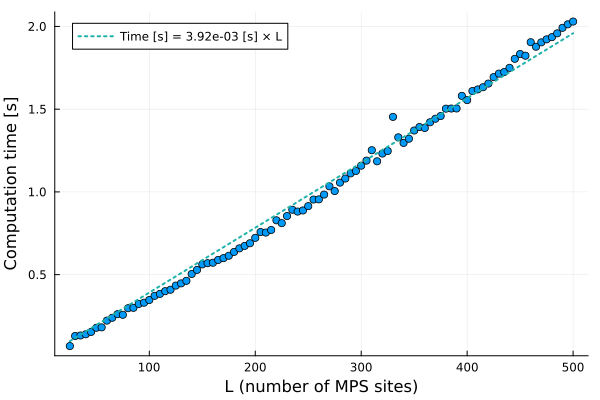

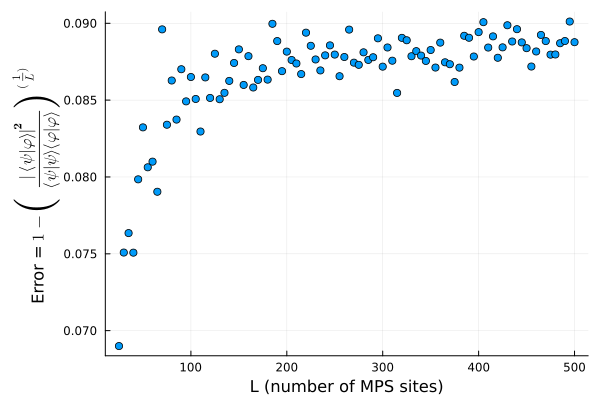

In [2]:
# initialize random tensor maps with the correct sizes for the approximated MPS 
# case1 - truncate a uniform MPS of chi = 20 to one of chi = 5




# Create a DMRG algorithm instance
alg = DMRG(;  # Choose DMRG (1-site) for this example
    maxiter = 40,  # Maximum number of iterations
    verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
    tol = 1e-24
)


physical_index = ℝ^2
max_virtualspace_exact = 10
max_virtualspace_approx = ℝ^5


time_taken_function_of_L = []
fidelity_in_function_of_L = []
L_list = [i for i in (25:5:500)]

@showprogress for L in L_list

    Ψ_exact, S_max = generate_entangled_mps(L, max_virtualspace_exact, 2)

    Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
        rand,                                                                   # with a smaller bond dimension
        Float64, 
        L, physical_index, 
        max_virtualspace_approx)

    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(Ψ_exact)), physicalspace(Ψ_exact, i))) for i in 1:length(Ψ_exact)]) # corresponding identity operator as an MPO
    if L == L_list[1]
        # initial run to initialize DMRG before timing
        # first run takes very long!!! otherwise the first data_point would be wrong
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    time_taken = @elapsed begin                                                 # time how long it takes to compute the approximation
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    push!(time_taken_function_of_L, time_taken)
    error = 1-(dot(Ψ_new, Ψ_exact)^2/(dot(Ψ_new, Ψ_new)*dot(Ψ_exact, Ψ_exact)))^(1/L)
    push!(fidelity_in_function_of_L, error)

end

# make a linear fit using LinearAlgebra - package
β = L_list \ time_taken_function_of_L
β_str = @sprintf("%.2e", β)

# Plot the results in function of L
p = Plots.scatter(L_list, time_taken_function_of_L, 
              xlabel="L (number of MPS sites)", 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
Plots.plot!(L_list, β * L_list, legend=true, label="Time [s] = $β_str [s] × L", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
savefig(p,"Computational_time_ifv_L.png")
display(p)

display(Plots.scatter(L_list, fidelity_in_function_of_L, 
              xlabel="L (number of MPS sites)", 
              ylabel="Error = " * L"1 - \left( \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}\right)^{(\frac{1}{L})}", 
              legend=false, left_margin = 5mm))


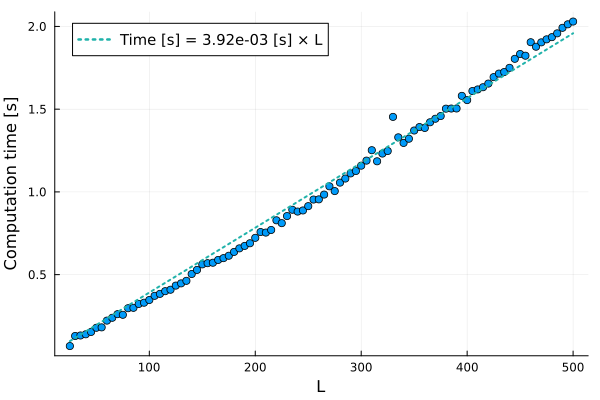

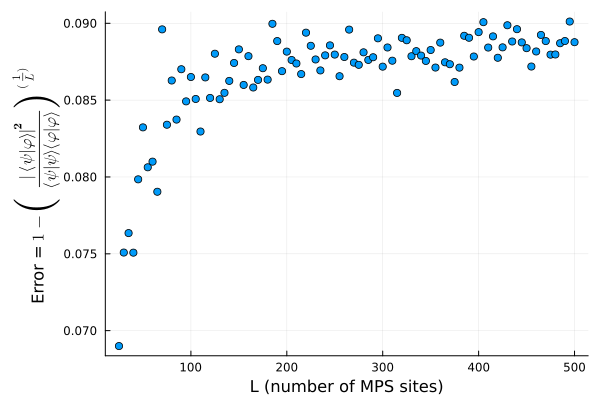

RMSE = 4.835e-02 [s]


In [16]:
# ERROR CALCULATIONS
# Plot the results in function of L
p = Plots.scatter(L_list, time_taken_function_of_L, 
              xlabel="L", 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
Plots.plot!(L_list, β * L_list, legend=true, label="Time [s] = $β_str [s] × L", linewidth=2, color=colorant"lightseagreen", linestyle=:dot, legendfontsize=10)
savefig(p,"Computational_time_ifv_L.svg")
display(p)

display(Plots.scatter(L_list, fidelity_in_function_of_L, 
              xlabel="L (number of MPS sites)", 
              ylabel="Error = " * L"1 - \left( \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}\right)^{(\frac{1}{L})}", 
              legend=false, left_margin = 5mm))

# Compute the fitted values
fitted_values = β * L_list

# Compute the residuals
residuals = time_taken_function_of_L .- fitted_values

# Compute the squared residuals
squared_residuals = residuals .^ 2

# Compute the mean of squared residuals
mean_squared_residuals = mean(squared_residuals)

# Compute the root mean square error (RMSE)
RMSE = sqrt(mean_squared_residuals)
rmse_str = @sprintf("%.3e", RMSE)
println("RMSE = $rmse_str [s]")

First of all measure the influence $\chi_{i}$ on the computation time to optimize the MPS using:\
\
L = 20 => max_D = 2^10 = 1024
R^range(10-1000) => R^10    \
sigma = R^2 \
DMRG1


┌ Warning: dmrg failed to converge 8.382970844695298e-16>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 8.382970844695298e-16>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 0.0061776510927291466>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
Progress:   5%|██                                       |  ETA: 0:10:49┌ Warning: dmrg failed to converge 0.006493933766810086>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 0.013606469231335492>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 0.00862697635991307>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:

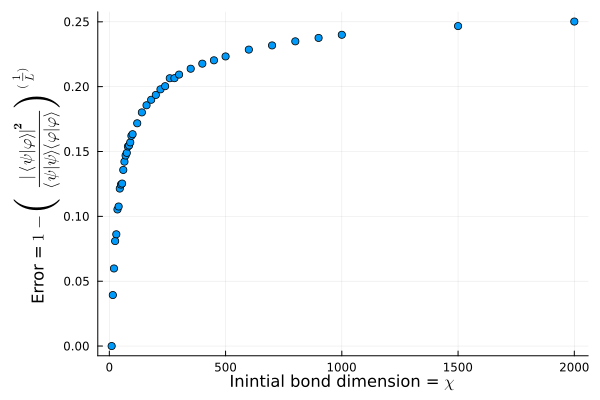

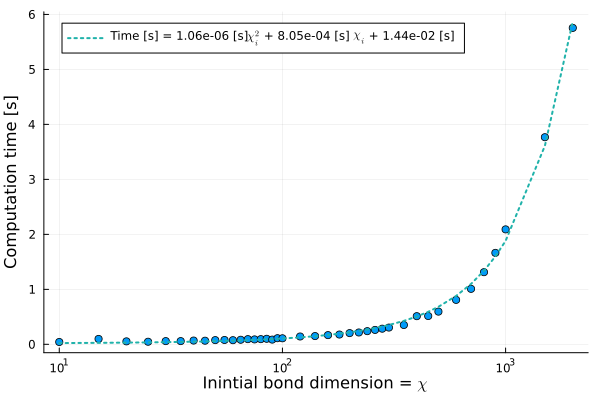

In [2]:
# initialize random tensor maps with the correct sizes for the approximated MPS 
# case1 - truncate a uniform MPS of chi = 20 to one of chi = 5
# Anala



# Create a DMRG algorithm instance
alg = DMRG(;  # Choose DMRG (1-site) for this example
    maxiter = 20,  # Maximum number of iterations
    verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
    tol = 1e-24
)


physical_index = ℝ^2
max_virtualspace_exact = vcat([i for i in 10:5:95], [i for i in 100:20:280],[i for i in 300:50:450], [i for i in 500:100:1000], [1500, 2000])
max_virtualspace_approx = ℝ^10
L = 22 # => chi_max = 2^10 = 1024

time_taken_function_of_chi_i = []
fidelity_in_function_of_chi_i = []
memory_in_function_of_chi_i = []

@showprogress for max_chi in max_virtualspace_exact

    Ψ_exact, S_max = generate_entangled_mps(L, max_chi, 2)

    Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
        rand,                                                                   # with a smaller bond dimension
        Float64, 
        L, physical_index, 
        max_virtualspace_approx)

    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(Ψ_exact)), physicalspace(Ψ_exact, i))) for i in 1:length(Ψ_exact)]) # corresponding identity operator as an MPO

    if max_chi == max_virtualspace_exact[1]
        # initial run to initialize DMRG before timing
        # first run takes very long!!! otherwise the first data_point would be wrong
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    time_taken = @elapsed begin                                                 # time how long it takes to compute the approximation
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))^(1/L)
    push!(memory_in_function_of_chi_i, current_mem_usage)
    push!(time_taken_function_of_chi_i, time_taken)
    error = 1-(dot(Ψ_new, Ψ_exact)^2/(dot(Ψ_new, Ψ_new)*dot(Ψ_exact, Ψ_exact)))
    push!(fidelity_in_function_of_chi_i, error)

end

#TODO: MAYBE average the computational time [s] over 10 runs? 

# Fitting to something 0(chi^3)? -> chi^2 theorically

# x = deepcopy(max_virtualspace_exact)
# y = Float64.(deepcopy(time_taken_function_of_chi_i))
# fit_result = CurveFit.poly_fit(x, y, 3)
# d, c, b, a = fit_result # (ax^3 + bx^2 + cx +d)

# y_fit = a*x.^3  .+ b*x.^2 .+c*x.+d
# a_str = @sprintf("%.2e", a)
# b_str = @sprintf("%.2e", b)
# c_str = @sprintf("%.2e", c)
# d_str = @sprintf("%.2e", d)



# # Plot the results in function of L
# p = Plots.scatter(max_virtualspace_exact, time_taken_function_of_chi_i, 
#               xlabel="Inintial bond dimension = " * L"\chi_i" , 
#               ylabel="Computation time [s]", 
#               label="",
#               legend=false)
# fullstring = "Time [s] = $a_str [s] × " * L"\chi^3" * " + $b_str [s] × " * L"\chi^2" * " + c $c_str [s] × " * L"\chi" * " + $d_str [s]"
# Plots.plot!(max_virtualspace_exact, y_fit, legend=true, label="Time [s] = 0($a_str [s] " * L"\chi^3)", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
# display(p)

display(Plots.scatter(max_virtualspace_exact, fidelity_in_function_of_chi_i, 
              xlabel="Inintial bond dimension = " * L"\chi", 
              ylabel="Error = " * L"1 - \left( \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}\right)^{(\frac{1}{L})}", 
              legend=false, left_margin = 5mm))



# Fitting to something 0(chi^2)? 

x = deepcopy(max_virtualspace_exact)
y = Float64.(deepcopy(time_taken_function_of_chi_i))
fit_result = CurveFit.poly_fit(x, y, 2)
c, b, a = fit_result # (ax^2 + bx + c)

y_fit = a*x.^2 .+ b*x .+ c
a_str = @sprintf("%.2e", a)
b_str = @sprintf("%.2e", b)
c_str = @sprintf("%.2e", c)



# Plot the results in function of χ initial

p = Plots.scatter(max_virtualspace_exact, time_taken_function_of_chi_i, 
              xlabel="Inintial bond dimension = " * L"\chi" , 
              ylabel="Computation time [s]", 
              label="",
              legend=false,xscale=:log10)
            #   yscale=:log10)
fullstring = "Time [s] = $a_str [s]" * L"\chi_i^2" * " + $b_str [s] " * L"\chi_i" * " + $c_str [s] " 
Plots.plot!(max_virtualspace_exact, y_fit, legend=true, label="$fullstring", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
display(p)





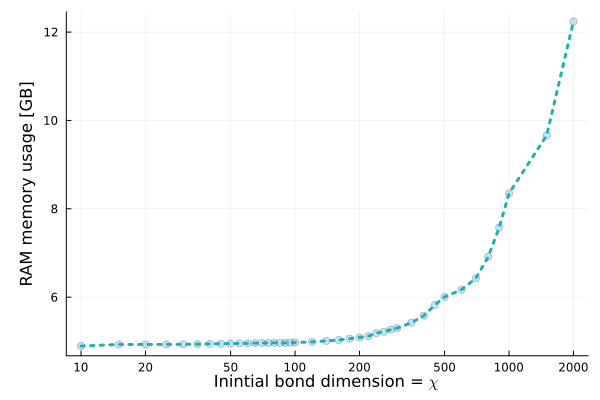

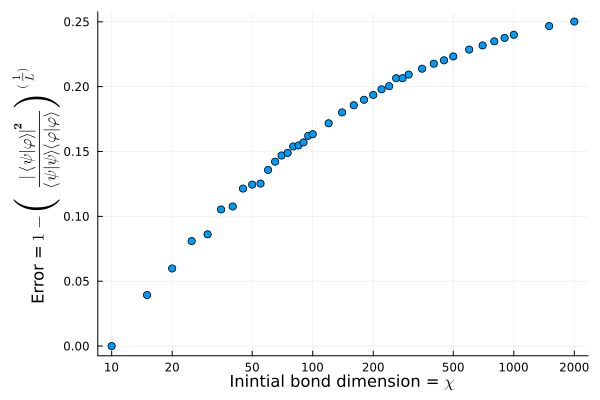

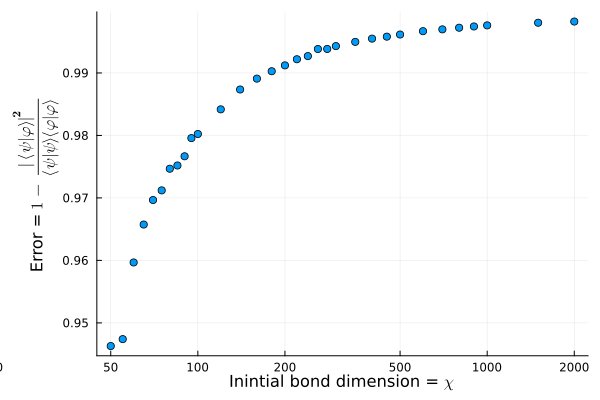

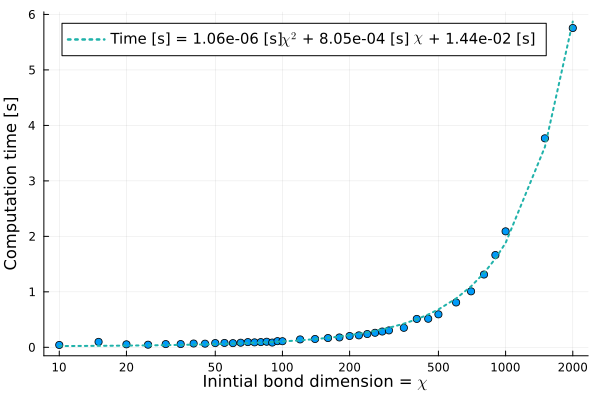

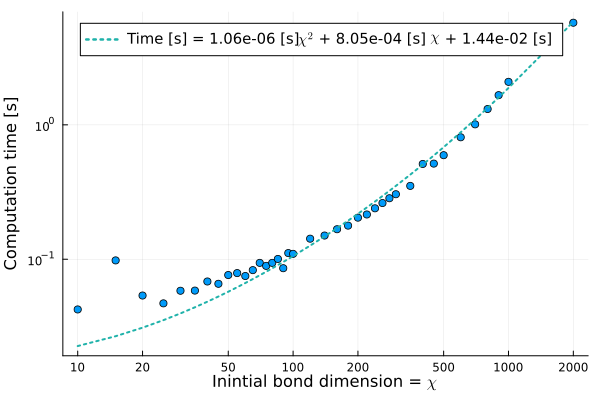

RMSE = 5.807e-02 [s]


In [49]:
fidelity_new = (fidelity_in_function_of_chi_i.-1)*(-1)
rescaled = fidelity_new.^(L)
error_new = 1 .-rescaled
error_new2 = [x == 0 ? 1e-16 : x for x in error_new]


p = (Plots.scatter(max_virtualspace_exact, memory_in_function_of_chi_i/(2^10), 
              xlabel="Inintial bond dimension = " * L"\chi", xscale=:log10, xticks=([10, 20, 50, 100, 200, 500, 1000, 2000], [10, 20, 50, 100, 200, 500, 1000, 2000]),
              ylabel="RAM memory usage [GB]", 
              legend=nothing, left_margin = 5mm, opacity=0.25))
Plots.plot!(max_virtualspace_exact, memory_in_function_of_chi_i/(2^10), color=colorant"lightseagreen", linestyle=:dot, linewidth=3, legend=false, label="Memory usage")             

savefig(p,"memoryusage ifv chi fidelity density.svg")
display(p)

p = (Plots.scatter(max_virtualspace_exact, fidelity_in_function_of_chi_i, 
              xlabel="Inintial bond dimension = " * L"\chi", xscale=:log10, xticks=([10, 20, 50, 100, 200, 500, 1000, 2000], [10, 20, 50, 100, 200, 500, 1000, 2000]),
              ylabel="Error = " * L"1 - \left(\textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}\right)^{(\frac{1}{L})}", 
              legend=false, left_margin = 5mm))
              

savefig(p,"Error ifv chi fidelity density.svg")
display(p)

p = (Plots.scatter(max_virtualspace_exact[9:end], error_new[9:end], 
              xlabel="Inintial bond dimension = " * L"\chi", xscale=:log10, xticks=([10, 20, 50, 100, 200, 500, 1000, 2000], [10, 20, 50, 100, 200, 500, 1000, 2000]),
              ylabel="Error = " * L"1 - \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}", 
              legend=false, left_margin = 5mm))
              

savefig(p,"Error ifv chi normal fidelity.svg")
display(p)



# Plot the results in function of χ initial

p = Plots.scatter(max_virtualspace_exact, time_taken_function_of_chi_i, 
              xlabel="Inintial bond dimension = " * L"\chi" , 
              ylabel="Computation time [s]", 
              label="",
              legend=false,xscale=:log10,  xticks=([10, 20, 50, 100, 200, 500, 1000, 2000], [10, 20, 50, 100, 200, 500, 1000,  2000]), legendfontsize=10)
            #   yscale=:log10)
fullstring = "Time [s] = $a_str [s]" * L"\chi^2" * " + $b_str [s] " * L"\chi" * " + $c_str [s] " 
Plots.plot!(max_virtualspace_exact, y_fit, legend=true, label="$fullstring", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)

savefig(p,"runtime ifv chi.svg")

display(p)

p = Plots.scatter(max_virtualspace_exact, time_taken_function_of_chi_i, 
xlabel="Inintial bond dimension = " * L"\chi" , 
ylabel="Computation time [s]", 
label="", yscale=:log10,
legend=false,xscale=:log10,  xticks=([10, 20, 50, 100, 200, 500, 1000, 2000], [10, 20, 50, 100, 200, 500, 1000,  2000]), legendfontsize=10)
#   yscale=:log10)
fullstring = "Time [s] = $a_str [s]" * L"\chi^2" * " + $b_str [s] " * L"\chi" * " + $c_str [s] " 
Plots.plot!(max_virtualspace_exact, y_fit, legend=true, label="$fullstring", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)

savefig(p,"runtime ifv chi loglog.svg")

display(p)          
# error calculations

residuals = time_taken_function_of_chi_i .- y_fit

# Compute the squared residuals
squared_residuals = residuals .^ 2

# Compute the mean of squared residuals
mean_squared_residuals = mean(squared_residuals)

# Compute the root mean square error (RMSE)
RMSE = sqrt(mean_squared_residuals)
rmse_str = @sprintf("%.3e", RMSE)
println("RMSE = $rmse_str [s]")

Measure the influence $\chi_{f}$ on the computation time to optimize the MPS using:\
\
L = 50 => max_D = large \
R^(100) => R^(5-50)    \
sigma = R^2 \
DMRG1


In [ ]:
# initialize random tensor maps with the correct sizes for the approximated MPS 
# case1 - truncate a uniform MPS of chi = 20 to one of chi = 5
# Create a DMRG algorithm instance
alg = DMRG(;  # Choose DMRG (1-site) for this example
    maxiter = 20,  # Maximum number of iterations
    verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
    tol = 1e-24
)


physical_index = ℝ^2
max_virtualspace_exact = 100
max_virtualspace_approx = ℝ^10
chi_approx_list = [(10 + (i-1)*3) for i in 1:30]
L = 50  # 2^10 = 1024 = max_D

time_taken_function_of_chi_f = []
fidelity_in_function_of_chi_f = []


@showprogress for max_chi in chi_approx_list

    Ψ_exact, S_max = generate_entangled_mps(L, max_virtualspace_exact, 2)

    Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
        rand,                                                                   # with a smaller bond dimension
        Float64, 
        L, physical_index, 
        ℝ^max_chi)

    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(Ψ_exact)), physicalspace(Ψ_exact, i))) for i in 1:length(Ψ_exact)]) # corresponding identity operator as an MPO

    time_taken = @elapsed begin                                                 # time how long it takes to compute the approximation
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    push!(time_taken_function_of_chi_f, time_taken)
    error = 1-(dot(Ψ_new, Ψ_exact)^2/(dot(Ψ_new, Ψ_new)*dot(Ψ_exact, Ψ_exact)))^(1/L)
    push!(fidelity_in_function_of_chi_f, error)

end

#TODO: MAYBE average the computational time [s] over 10 runs? 

# Fitting to something 0(chi^3)? 

x = deepcopy(chi_approx_list)
y = Float64.(deepcopy(time_taken_function_of_chi_f))
fit_result = CurveFit.poly_fit(x, y, 3)
d, c, b, a = fit_result # (ax^3 + bx^2 + cx +d)

y_fit = a*x.^3  .+ b*x.^2 .+c*x.+d
a_str = @sprintf("%.2e", a)
b_str = @sprintf("%.2e", b)
c_str = @sprintf("%.2e", c)
d_str = @sprintf("%.2e", d)



# Plot the results in function of L
p = Plots.scatter(chi_approx_list, time_taken_function_of_chi_f, 
              xlabel="Inintial bond dimension = " * L"\chi_i" , 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
fullstring = "Time [s] = $a_str [s] × " * L"\chi^3" * " + $b_str [s] × " * L"\chi^2" * " + c $c_str [s] × " * L"\chi" * " + $d_str [s]"
Plots.plot!(chi_approx_list, y_fit, legend=true, label="Time [s] = 0($a_str [s] " * L"\chi^3)", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
display(p)

display(Plots.scatter(chi_approx_list, fidelity_in_function_of_chi_f, 
              xlabel="Inintial bond dimension = " * L"\chi_i", 
              ylabel="Error = " * L"1 - \left( \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}\right)^{(\frac{1}{L})}", 
              legend=false, left_margin = 5mm))



# Fitting to something 0(chi^2)? 

x = deepcopy(chi_approx_list)
y = Float64.(deepcopy(time_taken_function_of_chi_f))
fit_result = CurveFit.poly_fit(x, y, 2)
c, b, a = fit_result # (ax^2 + bx + c)

y_fit = a*x.^2 .+ b*x .+ c
a_str = @sprintf("%.2e", a)
b_str = @sprintf("%.2e", b)
c_str = @sprintf("%.2e", c)



# Plot the results in function of L
p = Plots.scatter(chi_approx_list, time_taken_function_of_chi_f, 
              xlabel="Inintial bond dimension = " * L"\chi_i" , 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
fullstring = "Time [s] = $a_str [s]" * L"\chi^2" * " + $b_str [s] " * L"\chi" * " + $c_str [s] " 
Plots.plot!(chi_approx_list, y_fit, legend=true, label="Time [s] = $fullstring", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
display(p)

# Fitting to something 0(chi^2)? 

x = deepcopy(chi_approx_list)
y = Float64.(deepcopy(time_taken_function_of_chi_f))
fit_result = CurveFit.poly_fit(x, y, 1)
b, a = fit_result # ax + b)

y_fit = a*x .+ b
a_str = @sprintf("%.2e", a)
b_str = @sprintf("%.2e", b)



# Plot the results in function of L
p = Plots.scatter(chi_approx_list, time_taken_function_of_chi_f, 
              xlabel="Inintial bond dimension = " * L"\chi_i" , 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
fullstring = "Time [s] = $a_str [s] × " * L"\chi" * " + $b_str [s] "
Plots.plot!(chi_approx_list, y_fit, legend=true, label="Time [s] = $fullstring", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
display(p)


Measure the influence of the number of the amount of sweeps 
on the computation time to optimize the MPS using:\
\
L = 18 \
R^512 => R^64 \
sigma = R^2  \
DMRG1


┌ Warning: dmrg failed to converge 6.473375059436944e6>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 7.486582207153864e6>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 0.21938200101293176>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
Progress:   4%|█▋                                       |  ETA: 0:00:08┌ Warning: dmrg failed to converge 0.12290621291930601>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
Progress:   6%|██▌                                      |  ETA: 0:00:08┌ Warning: dmrg failed to converge 0.07855058286439585>1.0e-24
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
Progress:   8%|███▎                                     |  ETA: 0:00:07┌ Warning: dmrg f

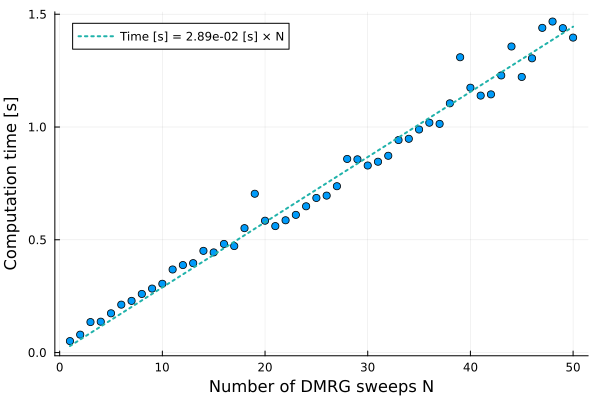

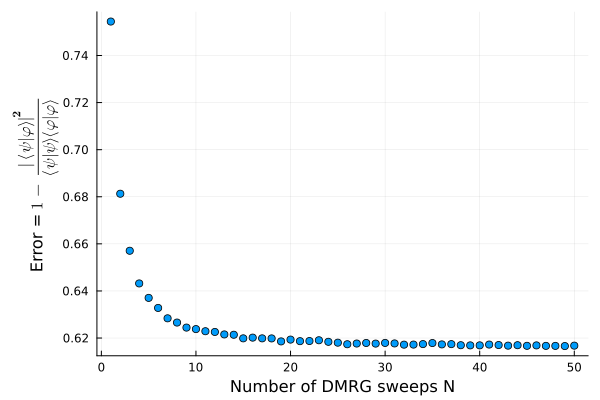

In [5]:
# initialize random tensor maps with the correct sizes for the approximated MPS 
# case1 - truncate a uniform MPS of chi = 20 to one of chi = 5




# Create a DMRG algorithm instance



physical_index = ℝ^2
max_virtualspace_exact = 512
max_virtualspace_approx = ℝ^64


time_taken_function_of_nr = []
fidelity_in_function_of_nr = []
max_iter_list = [j for j in 1:50]
L = 18

Ψ_exact, S_max = generate_entangled_mps(L, max_virtualspace_exact, 2)

Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
        rand,                                                                   # with a smaller bond dimension
        Float64, 
        L, physical_index, 
        max_virtualspace_approx)


@showprogress for max_it in max_iter_list

    alg = DMRG(;  # Choose DMRG (1-site) for this example
        maxiter = max_it,  # Maximum number of iterations
        verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
        tol = 1e-24
        )    
    
    

    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(Ψ_exact)), physicalspace(Ψ_exact, i))) for i in 1:length(Ψ_exact)]) # corresponding identity operator as an MPO

    if max_it == max_iter_list[1]
        # initial run to initialize DMRG before timing
        # first run takes very long!!! otherwise the first data_point would be wrong
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
            rand,                                                                   # with a smaller bond dimension
            Float64, 
            L, physical_index, 
            max_virtualspace_approx)

    time_taken = @elapsed begin                                                 # time how long it takes to compute the approximation
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    push!(time_taken_function_of_nr, time_taken)
    error = 1-(dot(Ψ_new, Ψ_exact)^2/(dot(Ψ_new, Ψ_new)*dot(Ψ_exact, Ψ_exact)))#^(1/L)
    push!(fidelity_in_function_of_nr, error)

end

# make a linear fit using LinearAlgebra - package
β = max_iter_list \ time_taken_function_of_nr
β_str = @sprintf("%.2e", β)

# Plot the results in function of L
p = Plots.scatter(max_iter_list, time_taken_function_of_nr, 
              xlabel="Number of DMRG sweeps N", 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
Plots.plot!(max_iter_list, β * max_iter_list, legend=true, label="Time [s] = $β_str [s] × N", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
display(p)

display(Plots.scatter(max_iter_list, fidelity_in_function_of_nr, 
              xlabel="Number of DMRG sweeps N", 
              ylabel="Error = " * L"1 - \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}", 
              legend=false, left_margin = 5mm))


In [2]:
#error analysis:

# Plot the results in function of L
p = Plots.scatter(max_iter_list, time_taken_function_of_nr, 
              xlabel="Number of DMRG sweeps N", 
              ylabel="Computation time [s]", 
              label="",
              legend=false, legendfontsize=10)
Plots.plot!(max_iter_list, β * max_iter_list, legend=true, label="Time [s] = $β_str [s] × N", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
savefig(p,"Computational_time_ifv_N.svg")

display(p)

p = Plots.scatter(max_iter_list, fidelity_in_function_of_nr, 
              xlabel="Number of DMRG sweeps N", 
              ylabel="Error = " * L"1 - \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}", 
              legend=false, left_margin = 5mm)
savefig(p,"Error_ifv_N.svg")

# Compute the fitted values
fitted_values = β * max_iter_list

# Compute the residuals
residuals = time_taken_function_of_nr .- fitted_values

# Compute the squared residuals
squared_residuals = residuals .^ 2

# Compute the mean of squared residuals
mean_squared_residuals = mean(squared_residuals)

# Compute the root mean square error (RMSE)
RMSE = sqrt(mean_squared_residuals)
rmse_str = @sprintf("%.3e", RMSE)
println("RMSE = $rmse_str [s]")
println(Sys.total_memory / 2^20)

UndefVarError: UndefVarError: `max_iter_list` not defined